In [105]:
!pip install torchsummary

In [106]:
import torch
from torch import nn

import torch.optim as optim
from itertools import chain

from torch.utils.data import DataLoader, TensorDataset, Dataset

from torchsummary import summary
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import random

random.seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

import torchvision.datasets

In [107]:
MNIST_train=torchvision.datasets.MNIST('./data', download = True, train = True)
MNIST_test=torchvision.datasets.MNIST('./data', download = True, train = False)

# Автокодировщик для удаления шума

In [108]:
X_train = MNIST_train.data/255
X_test = MNIST_test.data/255

noise = 0.5 #чем выше значение, тем более зашумленные данные

X_train_noise = X_train + noise * np.random.normal(loc = 0, scale=1 ,size = X_train.shape)
X_test_noise = X_test + noise * np.random.normal(loc = 0, scale=1 ,size = X_test.shape)

X_train=X_train.to(torch.float32) #данные без шума
X_test=X_test.to(torch.float32)

X_train_noise=X_train_noise.to(torch.float32) #данные с шумом для проверки работы автокодировщика
X_test_noise=X_test_noise.to(torch.float32)

X_train_noise = X_train_noise.unsqueeze(1)
X_train = X_train.unsqueeze(1)
X_test_noise = X_test_noise.unsqueeze(1)
X_test = X_test.unsqueeze(1)
X_train_noise.shape, X_train.shape, X_test_noise.shape, X_test.shape

(torch.Size([60000, 1, 28, 28]),
 torch.Size([60000, 1, 28, 28]),
 torch.Size([10000, 1, 28, 28]),
 torch.Size([10000, 1, 28, 28]))

Данные с шумом мы используем для входа в сеть, а данные без шума - для оценки качества результата

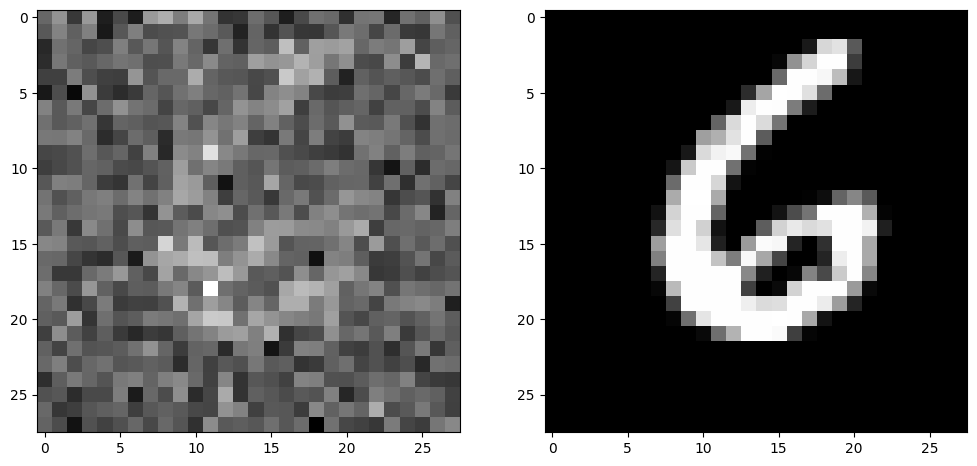

In [109]:
fig, axs = plt.subplots(1, 2, figsize=(12, 12))
axs[0].imshow(X_train_noise[90][0], cmap='gray')
axs[1].imshow(X_train[90][0], cmap='gray')

In [110]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [111]:
class Encoder(torch.nn.Module):
    def __init__(self):
        super().__init__()

        #ВАШ_КОД
        in_channels = 1
        self.conv2d_1 = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=5, stride=1)        
        self.relu = nn.ReLU()
        self.maxpool2d_1 =  nn.MaxPool2d(kernel_size=2)
        
        self.conv2d_2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1)        
        self.maxpool2d_2 =  nn.MaxPool2d(kernel_size=2)
        
        self.conv2d_3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1)        
        self.maxpool2d_3 =  nn.MaxPool2d(kernel_size=2)
        
        
    
    def forward(self, x):
        #ВАШ_КОД
        y = self.relu(self.conv2d_1(x))
        y = self.maxpool2d_1(y)
        y = self.relu(self.conv2d_2(y))
        y = self.maxpool2d_2(y)
        y = self.relu(self.conv2d_3(y))
        y = self.maxpool2d_3(y)
        
        
        return y   


In [112]:
class Decoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #размерность выход энкодера должна совпадать размерностью входа декодера

        #здесь нужно использовать метод torch.nn.Upsample(scale_factor=2),(см. документацию) или ConvTranspose2d (см. документацию)
        #так как необходимо уменьшенное пространство преобразовать в исходное, размером 28 на 28
        #используйте свертки, функции активации, Upsample, падинги

        #ВАШ_КОД
        self.convtr2d_1 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3)
        self.relu = nn.ReLU()
        
        self.convtr2d_2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3)
        self.upsample_1 = nn.Upsample(scale_factor=2)
        
        self.convtr2d_3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3)
        self.upsample_2 = nn.Upsample(scale_factor=2)
        
        self.convtr2d_4 = nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=5)

    def forward(self, x):
        
        #ВАШ_КОД
        y = self.relu(self.convtr2d_1(x))
        y = self.relu(self.convtr2d_2(y))
        y = self.upsample_1(y)
        y = self.relu(self.convtr2d_3(y))
        y = self.upsample_2(y)
        y = self.relu(self.convtr2d_4(y))
        
        return y


In [113]:
def train_ae(data_loader, encoder, decoder, epochs, lr):
    encoder.train()
    decoder.train()
    print('Обучение автокодировщика..')

    loss_func = nn.MSELoss()
    optimizer = optim.Adam(chain(encoder.parameters(), decoder.parameters()), lr=lr)
    loss_history = list()
    for epoch in range(epochs):
        for (batch, val) in data_loader:
            #batch -- это данные с шумом
            #val -- данные без шума
            batch = batch.to(device)
            val = val.to(device)
            #ВАШ_КОД
            optimizer.zero_grad()

            loss = loss_func(decoder(encoder(batch)), val)
            loss.backward()
            optimizer.step()
            

            #ВАШ_КОД

            loss_history.append(loss.log().item())
        print(f'Эпоха {epoch + 1} / {epochs}. Потери на последнем пакете: {loss.item()}')

    print('Готово!')

    encoder.eval()
    decoder.eval()

    plt.plot(loss_history)
    plt.show()

In [114]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)

In [115]:
#сделать даталоадер, в котором будут данные с шумом для обучения и таргеты - данные без шума

In [116]:
train_data_loader = DataLoader(list(zip(X_train_noise, X_train)), batch_size=256, shuffle=True)

Обучение автокодировщика..
Эпоха 1 / 10. Потери на последнем пакете: 0.02668890729546547
Эпоха 2 / 10. Потери на последнем пакете: 0.01884648948907852
Эпоха 3 / 10. Потери на последнем пакете: 0.01768585667014122
Эпоха 4 / 10. Потери на последнем пакете: 0.01665472239255905
Эпоха 5 / 10. Потери на последнем пакете: 0.014975008554756641
Эпоха 6 / 10. Потери на последнем пакете: 0.01534564420580864
Эпоха 7 / 10. Потери на последнем пакете: 0.013721799477934837
Эпоха 8 / 10. Потери на последнем пакете: 0.014268657192587852
Эпоха 9 / 10. Потери на последнем пакете: 0.013159234076738358
Эпоха 10 / 10. Потери на последнем пакете: 0.013338089920580387
Готово!


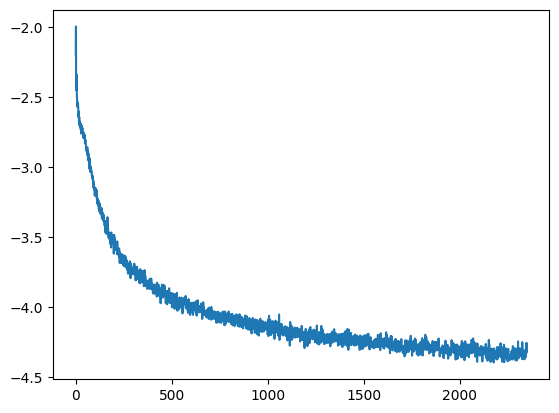

In [117]:
EPOCHS= 10
LR= 0.001
train_ae(train_data_loader, encoder, decoder, EPOCHS, LR)

In [118]:
X_test_noise = X_test_noise.to(device)
result = decoder(encoder(X_test_noise[:6]))

In [119]:
result.shape
X_test_noise = X_test_noise.detach().cpu().numpy()
result = result.detach().cpu().numpy()


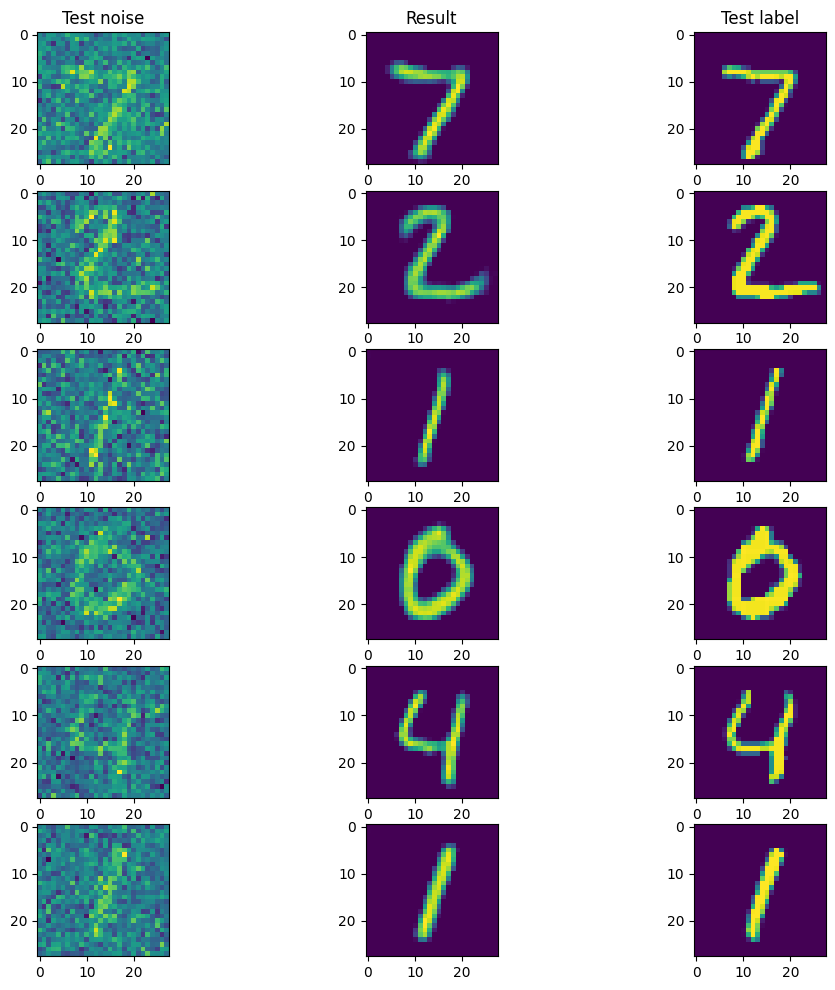

In [120]:
#показать результат удаления шума из данных
#подать на вход энкодеру картинку в шумом, выход энкодера скормить декодеру и вывести результат
h = 6
fig, axs = plt.subplots(h, 3, figsize=(12, 12))

for i in range(len(result)):
    if i==0:
        axs[i,0].set_title('Test noise')
        axs[i,1].set_title('Result')
        axs[i,2].set_title('Test label')
    axs[i,0].imshow(X_test_noise[i][0])
    axs[i,1].imshow(result[i][0])
    axs[i,2].imshow(X_test[i][0])